# 데이터 관련

In [1]:
import pandas as pd
import ast
file_path = '/home/elicer/project/data/filtered_results.csv'
gt =pd.read_csv(file_path)
gt.head()

,File,Similarity Count,Similarity
0,TRAAABD128F429CF47,19,"[['TRBRSNN128F4284E8C', 1], ['TRZCLXJ128F429CF..."
1,TRAABJV128F1460C49,28,"[['TRSLCDZ128E07847D6', 0.426994], ['TRLIQKZ12..."
2,TRAADNA128F9331246,11,"[['TRBWFIV128F9331289', 1], ['TRDHRYP128F42790..."
3,TRAADQX128F422B4CF,7,"[['TRBEAWP128F422B4D1', 1], ['TROHCDR128F422B4..."
4,TRAAGJV128F1464090,31,"[['TRDRFLI128F92C94CB', 1], ['TRQQEEF128F92D5B..."


In [2]:
gt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   File              63 non-null     object
 1   Similarity Count  63 non-null     int64 
 2   Similarity        63 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [3]:

# 전체 파일 이름을 리스트로 저장
file_list = gt['File'].tolist()

unique_keys = set()

for idx, row in gt.iterrows():
    column_Value = row["Similarity"]
    list_value = ast.literal_eval(column_Value)
    for item in list_value:
        unique_keys.add(item[0])


list_sim = list(unique_keys)
final = list(set(list_sim)-set(file_list))

print(len(final))

619


In [4]:
print(final)

['TRCKPZJ128F92CA494', 'TRMQOJU128F4259DAC', 'TROOWWY128F14560A8', 'TRLZFVR128F92D1D86', 'TRFVCLW128F1497DD8', 'TRAYTWK12903CD6B16', 'TRYVDLP128F422B47D', 'TRROEBZ128F92CAE53', 'TRHVZDT128F427EFBE', 'TRDZEOT128F145B002', 'TRFXTBJ128F1465874', 'TRQMXHY128F1468853', 'TRJPESP128EF342B65', 'TRAVRZW128F932016E', 'TRZVIDL128F931B19E', 'TRTKBVO128F421AB7E', 'TRYSJDG128F14560AE', 'TRMQSLZ128F428B1C9', 'TRFPLHY128F9302C67', 'TRCEKLJ12903CB6ACE', 'TREICIT128F9359DA8', 'TRDLEJY128F92E153F', 'TRJPMCX12903CF1B39', 'TRWTDUC128F4259A40', 'TRFKEVF12903CECBD3', 'TRGGNMC128F42894E5', 'TRPMHHP128F933DB50', 'TRMBUHN128F42A9F8E', 'TRSSLHF128F92E16B3', 'TRRDUWV12903CAC435', 'TRWQHZM12903CDDB07', 'TREWHNG128F4286447', 'TRSMOAJ128F934184F', 'TRMMATD128F932C32B', 'TRDTXFH128E07929F6', 'TRSJZDC12903CE6DB1', 'TRMLNTN128F9330FC7', 'TREYGEV128F93233AB', 'TRQQSMQ128F1463FE6', 'TREQWFI128F92CAE57', 'TRKIZQD128F42BCBDB', 'TRWGKXT128F427896B', 'TRDLVIC128F933B0E7', 'TRENDJC128F42790D9', 'TRJLDQI128F427E5B5', 'TRYQKMW1

In [6]:
top5_sets = []

for i, row in gt.iterrows():
    similarity_list = eval(row['Similarity'])

      # 자기 자신 제외하고 유사도 내림차순으로 정렬
    sorted_similarity = sorted(similarity_list, key=lambda x: x[1], reverse=True)
    top5_similarity_ids = [item[0] for item in sorted_similarity if item[1] < 1][:5]

    top5_sets.append(top5_similarity_ids)
  

gt["Set"]. append(top5_similarity_ids)

gt['SET'] = top5_sets

KeyError: 'Set'

### mp3 확인

In [1]:
import os
import numpy as np

mp3 = os.listdir('/home/elicer/project/collect_data/mp3')
print(len(mp3)) #680
print(len(np.unique(mp3))) #680 ->  중복 없음

680
680


# Test MP3 임베딩 만들기 (stage 1)

## Test Dataloader

In [7]:

# ------------
# AudioDataset
# ------------
import os
import torchaudio
import torch
from torch.utils.data import Dataset
import re
import numpy as np
from torch import Tensor
import pandas as pd
from torch.utils.data import DataLoader
from typing import Tuple, List
import random

class AudioDataset(Dataset):
    def __init__(self, file_paths):
        """
        Contrastive Learning용 오디오 데이터셋.
        Args:
            file_paths (list): 오디오 파일 경로 리스트.
            transform (callable, optional): 데이터 증강을 위한 함수.
        """
        self.file_paths = file_paths
       

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # 오디오 파일 로드
        file_path = self.file_paths[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        
       

        return waveform, file_path #file_path가 track_id



def create_contrastive_datasets(dataset_dir):
    file_paths = [
        os.path.join(dataset_dir, f)
        for f in os.listdir(dataset_dir)
    ]

    test_dataset=AudioDataset(file_paths)

    return test_dataset



class ContrastiveDataset(Dataset):
    def __init__(self, dataset: Dataset,  input_shape: List[int]):
        # dir : sim_set이 들어있는 최종 csv 파일 경로
        self.dataset = dataset

        self.input_shape = input_shape
        self.ignore_idx = []
    
    def __getitem__(self, idx) -> Tuple[Tensor, Tensor]:
    
        sample_rate = 44100
        range = sample_rate * 15

        if idx in self.ignore_idx:
            return self[idx + 1]

        try:
            audio, file_path = self.dataset[idx]

            if audio is None or audio.shape[1] - (range * 2) < self.input_shape[1]:  # 오디오가 None이거나 길이가 짧으면 제외
                self.ignore_idx.append(idx)
                return self[idx + 1]

            # 전반부와 후반부로 나누고 각각 연속된 클립 선택
            mid_point = audio.shape[1] // 2
            first_half = audio[:, range:mid_point]
            second_half = audio[:, mid_point:audio.shape[1] - range]

            # 연속된 클립 추출
            clip_a = self._get_continuous_clip(first_half)
            clip_b = self._get_continuous_clip(second_half)

            # 파일 경로에서 파일 이름(ID) 추출
            file_name = os.path.basename(file_path)
            file_id = os.path.splitext(file_name)[0]

            # # file_id를 기준으로 CSV에서 target_column 값 가져오기
            # target_value = None
            # if file_id in self.metadata.iloc["Track ID"].values:  # 첫 번째 열에 file_id가 있는지 확인
            #     row = self.metadata[self.metadata.iloc[:, 0] == file_id]
            #     target_value = row[self.target_column].values[0]  # 특정 열 값 가져오기

            # # target_value가 None인 경우, 데이터 건너뛰기
            # if target_value is None:
            #     self.ignore_idx.append(idx)
            #     return self[idx + 1]

            #---------------------------
            #원핫벡터로 target value 설정
            
            

            # None 값 확인
            if clip_a is None or clip_b is None or file_id is None :
                self.ignore_idx.append(idx)
                print('넘어감')
                return self[idx + 1]

            # if target_value is None:
            #     self.ignore_idx.append(idx)
            #     return self[idx + 1]
            # 클립 A, 클립 B, 곡 ID, 타겟 값을 반환
            return clip_a, clip_b, file_id

        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            self.ignore_idx.append(idx)
            return self[idx + 1]



    def __len__(self) -> int:
        return len(self.dataset)

    def _get_continuous_clip(self, audio: Tensor) -> Tensor:
        """오디오에서 연속된 길이의 클립을 추출하는 메서드"""
        clip_length = self.input_shape[1]  # 원하는 클립 길이
        max_start_idx = audio.shape[1] - clip_length
        start_idx = random.randint(0, max_start_idx)  # 연속된 구간을 선택하기 위해 랜덤 인덱스 선택
        clip = audio[:, start_idx:start_idx + clip_length]
        
       
        
        return clip


In [8]:
dataset_dir = "/home/elicer/project/collect_data/mp3"
test_dataset = create_contrastive_datasets(dataset_dir)

sample_rate = 44100 # [1, sample_rate*30]: 30초로 구간 설정
test_contrastive_dataset = ContrastiveDataset(test_dataset,  input_shape=[1, sample_rate*30])

print(len(test_contrastive_dataset))
batch_size = 68 # 모든 노래 사용하기 위해서 batch_size = 68로 변경
test_loader = DataLoader(test_contrastive_dataset, batch_size=batch_size, shuffle=False, drop_last=False)


680


In [9]:
##### 확인용
# 배치 하나만 가져오기
batch = next(iter(test_loader))

# 배치 확인
clip_a, clip_b, file_id = batch
print(file_id[0])

KeyboardInterrupt: 

In [10]:
import sys
import os

sys.path.append(os.path.abspath('/home/elicer/project/src'))

from models import ContrastiveModel
from ast_encoder import ASTEncoder
from loss import soft_info_nce_loss, info_nce_loss
from loss_weight import generate_lyrics_embeddings, compute_similarity

import argparse
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import torch
import re
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import cosine_similarity

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# WNS_model_1203 불러와서 테스트

In [12]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

stage1_model = torch.load('/home/elicer/project/src/WNS_model_1203.pth')
stage1_model.eval()  # Stage 1은 학습하지 않음
stage1_model.to(device)

music_data = []

for batch in test_loader:

    clip_a, clip_b, file_ids = batch
    clip_a, clip_b= clip_a.to(device), clip_b.to(device)

    with torch.no_grad():  # Stage 1은 학습하지 않음
        stage1_model = stage1_model.to(clip_a.device)
        emb1,emb2 = stage1_model(clip_a, clip_b, device)
        emb1 = emb1.cpu().numpy()

    for file_id, embedding in zip(file_ids, emb1):
        music_data.append({'id': file_id, 'embedding': embedding})
    


df = pd.DataFrame(music_data)
df.to_csv("WNS_model_1203_predicted_embedding_all.csv", index=False)
print(df)

/tmp/ipykernel_42492/815281448.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stage1_model = torch.load('/home/elicer/project/src/WNS_model_1203.pth')


KeyboardInterrupt: 

### Norm 포함

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize


#optimal에서 Anchor Id만 추출하기
optimal_df = pd.read_csv('/home/elicer/project/data/optimal_optimal_data.csv') 
filtered_optimal_df = optimal_df[optimal_df['IsInAnchor'] == 1] 
track_ids = filtered_optimal_df['Track ID'].tolist() #anchor의 track_id list

anchor_df = df[df['id'].isin(track_ids)] #anchor의 df (track_id + embedding)
anchor_embeddings = np.stack(anchor_df['embedding'].values)  # anchor의 임베딩 배열 

ohters_df = df[~df['id'].isin(track_ids)]
others_embeddings = np.stack(ohters_df['embedding'].values)

all_embeddings = np.vstack([anchor_embeddings, others_embeddings])  # anchor와 다른 임베딩을 합침

normalized_embeddings = normalize(all_embeddings, norm='l2')

# 정규화된 앵커 임베딩과 다른 임베딩 분리하기
normalized_anchor_embeddings = normalized_embeddings[:len(anchor_embeddings)]  # 정규화된 앵커 임베딩
normalized_others_embeddings = normalized_embeddings[len(anchor_embeddings):]  # 정규화된 다른 임베딩

# Cosine Similarity 계산 및 Top 5 & 10 유사 음악 ID 추가
top5_sets = []
top10_sets = []

for i in range(len(anchor_embeddings)): #56개

    # 현재 음악과 다른 모든 음악과의 유사도를 계산
    normalized_embeddings = normalized_anchor_embeddings[i] # 현재 음악(anchor 중 한개)

    similarities = [
        cosine_similarity(normalized_embeddings.reshape(1, -1), normalized_others_embeddings[j].reshape(1, -1)).flatten()
        for j in range(len(normalized_others_embeddings))
    ] # 한 앵커에 대해서 다른 노래들과 similarity 계산

    similarities = [item[0] for item in similarities] # value만 추출
    similarities = np.array(similarities)
    sorted_indices = similarities.argsort()[::-1]  # 유사도를 내림차순 정렬

    top5_indices = [idx for idx in sorted_indices if idx != i][:5]  # 자기 자신 제외하고 상위 5개
    top5_ids = df.iloc[top5_indices]['id'].tolist()  # 해당 인덱스의 ID 가져오기
    top5_sets.append(top5_ids)

    top10_indices = [idx for idx in sorted_indices if idx != i][:10]  # 자기 자신 제외하고 상위 10개
    top10_ids = df.iloc[top10_indices]['id'].tolist()  # 해당 인덱스의 ID 가져오기
    top10_sets.append(top10_ids)

# SET 칼럼 추가
anchor_df['SET_5'] = top5_sets
anchor_df['SET_10'] = top10_sets

In [13]:
len(df['embedding'].iloc[0])

128

In [25]:
from sklearn.metrics.pairwise import cosine_similarity


#optimal에서 Anchor Id만 추출하기
optimal_df = pd.read_csv('/home/elicer/project/data/optimal_optimal_data.csv') 
filtered_optimal_df = optimal_df[optimal_df['IsInAnchor'] == 1] 
track_ids = filtered_optimal_df['Track ID'].tolist() #anchor의 track_id list

anchor_df = df[df['id'].isin(track_ids)] #anchor의 df (track_id + embedding)
anchor_embeddings = np.stack(anchor_df['embedding'].values)  # anchor의 임베딩 배열 

# Cosine Similarity 계산 및 Top 5 유사 음악 ID 추가
top5_sets = []
for i in range(len(anchor_embeddings)): #56개
    others_embeddings = np.stack(df['embedding'].values) #다른 모든 곡의 임베딩 배열
    
    # 현재 음악과 다른 모든 음악과의 유사도를 계산
    embeddings = anchor_embeddings[i] # 현재 음악(anchor 중 한개)

    similarities = [
        cosine_similarity(embeddings.reshape(1, -1), others_embeddings[j].reshape(1, -1)).flatten()
        for j in range(len(others_embeddings))
    ] # 한 앵커에 대해서 다른 노래들과 similarity 계산

    similarities = [item[0] for item in similarities] # value만 추출
    similarities = np.array(similarities)

    sorted_indices = similarities.argsort()[::-1]  # 유사도를 내림차순 정렬
    top5_indices = [idx for idx in sorted_indices if idx != i][:5]  # 자기 자신 제외하고 상위 5개

    top5_ids = df.iloc[top5_indices]['id'].tolist()  # 해당 인덱스의 ID 가져오기
    top5_sets.append(top5_ids)

# SET 칼럼 추가
anchor_df['SET'] = top5_sets


NameError: name 'df' is not defined

In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity


# #optimal에서 Anchor Id만 추출하기
# optimal_df = pd.read_csv('/home/elicer/project/data/optimal_optimal_data.csv') 
# filtered_optimal_df = optimal_df[optimal_df['IsInAnchor'] == 1] 
# track_ids = filtered_optimal_df['Track ID'].tolist() #anchor의 track_id list

# filtered_embeddings = df[df['id'].isin(track_ids)] #anchor의 df (track_id + embedding)

# # Cosine Similarity 계산 및 Top 5 유사 음악 ID 추가
# embeddings = np.stack(filtered_embeddings['embedding'].values)  # anchor의 임베딩 배열 생성

# top5_sets = []
# for i in range(len(embeddings)):
#     # 현재 음악과 다른 모든 음악과의 유사도를 계산
#     similarities = cosine_similarity(embeddings, embeddings[i:i+1]).flatten()
#     sorted_indices = similarities.argsort()[::-1]  # 유사도를 내림차순 정렬

#     top5_indices = [idx for idx in sorted_indices if idx != i][:5]  # 자기 자신 제외하고 상위 5개
#     top5_ids = df.iloc[top5_indices]['id'].tolist()  # 해당 인덱스의 ID 가져오기
#     top5_sets.append(top5_ids)

# # SET 칼럼 추가
# filtered_embeddings['SET'] = top5_sets


In [7]:
anchor_df.to_csv("top_all_set_WNS_model_1203_predicted.csv", index=False)

In [8]:
anchor_df.head()

,id,embedding,SET
0,TRAAABD128F429CF47,"[0.296843, -10.305374, -5.2840333, -14.618581,...","[TRRLFOQ128F147C837, TRFOOZJ128F1461183, TRTXO..."
1,TRAADNA128F9331246,"[6.1910386, -6.832812, -5.54071, -9.203246, -1...","[TRWESMP128F145FE46, TRZKOPA128F92FFB93, TRXMF..."
2,TRAADQX128F422B4CF,"[-45.990276, 1.0430254, 23.494173, -42.120045,...","[TRNUTRR128E0791306, TRAUEWN128F932C32C, TRTOO..."
3,TRAAGJV128F1464090,"[-28.452686, -8.0084915, 28.35335, -19.579794,...","[TRJZRUB128F145993D, TRYXVJO128F14A3A77, TRROS..."
4,TRAAPPQ128F14961F5,"[7.5595975, 8.436234, -11.273859, -10.154662, ...","[TRFTBQA128F1463713, TRADRLH128F4265C65, TRRMJ..."


평가

In [1]:
import ast
import pandas as pd
#ground truth similarity 불러오기
ground_sim = pd.read_csv("/home/elicer/project/data/filtered_results.csv")


#ground sim에서 top 5 set뽑기
def extract_top_similar_ids(df_new, k=5):
    predicted_sets = []
    for _, row in df_new.iterrows():

        # 문자열을 리스트로 변환
        similarities = ast.literal_eval(row['Similarity'])

        # Similarity 기준으로 정렬 (높은 순)
        sorted_similarities = sorted(
            similarities, 
            key=lambda x: x[1] if isinstance(x[1], (int, float)) else 0, 
            reverse=True
        )
        
        # 현재 행의 File 값 제외하고 상위 k개 ID 추출
        top_k_ids = [
            id_sim[0] for id_sim in sorted_similarities 
            if id_sim[0] != row['File']
        ][:k]
        
        predicted_sets.append(top_k_ids)
    
    return predicted_sets

#ground_truth에서 전체 그냥 뽑기
def extract_all_similar_ids(df_new):
    all_predicted_ids = []
    for _, row in df_new.iterrows():
        # 문자열을 리스트로 변환
        similarities = ast.literal_eval(row['Similarity'])
        
        # 현재 행의 File 값 제외하고 모든 ID 추출
        ids = [id_sim[0] for id_sim in similarities if id_sim[0] != row['File']]
        
        all_predicted_ids.append(ids)  # 모든 ID를 리스트에 추가

    return all_predicted_ids


#recall평가
def calculate_recall_at_k(ground_truth, predictions, k=5):
    total_recall = 0
    for gt, pred in zip(ground_truth, predictions):
        # 교집합 계산
        intersection = len(set(gt) & set(pred))
        
        # Recall@k 계산
        recall = intersection / len(gt) if len(gt) > 0 else 0
        total_recall += recall
    
    # 평균 Recall@k
    return total_recall / len(ground_truth)

In [2]:
ground_truth = extract_top_similar_ids(ground_sim, k=5)
anchor_df = pd.read_csv("top_all_set_WNS_model_1203_predicted.csv")

predicted_sets = anchor_df['SET'].tolist()
print((predicted_sets[0]))
# recall_5 = calculate_recall_at_k(ground_truth, predicted_sets, k=5)
# print("Recall@5:", recall_5)

['TRRLFOQ128F147C837', 'TRFOOZJ128F1461183', 'TRTXORS128F92FA8DB', 'TRAJBTZ12903CB818C', 'TRZSXBS128F4268C9C', 'TRLZFVR128F92D1D86', 'TRJGMBL128F4233D00', 'TRJZMIE128E0794201', 'TRVHNDP128F4223058', 'TRVDFFJ128F92F3C97', 'TRONAWX128F93351E3', 'TRHAWEE128F9326748', 'TRDRJDF128F4282E67', 'TRUEBCW128F933B3F8', 'TRPKZZT128F92FE049', 'TRLAWYF128F4272354', 'TRUNUID128F92E28F8', 'TRZODUN128F42440AB', 'TRBZNMB128F9307828', 'TRATJXC128F93124CE', 'TRJHWMF128E0787385', 'TREYVSY12903D080BF', 'TRSNIUB12903CB0090', 'TRIGVAF12903CF4186', 'TRBCVPD12903CECBE8', 'TRQAJVJ128F93190F4', 'TRQIAWX12903CB8192', 'TRSBEHO128F92FA3E2', 'TRMVWBS128F148EEB6', 'TRVNAWN128F428837A', 'TRIFBMA128F147EE95', 'TRWNGZN128F14895B2', 'TRAXCZO12903CB819D', 'TRZVIDL128F931B19E', 'TRGBCXZ128F145FB15', 'TRGMKTI128F1477475', 'TRZAWBV128F92FE646', 'TRZPDHG128F423EEAD', 'TROSMPF128F93335F4', 'TRLJYXC128F1466737', 'TRGLNFK128F422305E', 'TRTWDQD12903CC4537', 'TRRIJBS128F92F733A', 'TRGUGPC12903CB81A7', 'TRAHWNC128F428E2B9', 'TRYYJQW1

###

### 이전 recall (건들지 말기)

상위 5개 vs 상위 5개 recall하니까 0 나옴

In [20]:
ground_truth = extract_top_similar_ids(ground_sim)
predicted_sets = anchor_df['SET'].tolist()

recall_5 = calculate_recall_at_k(ground_truth, predicted_sets, k=5)
print("Recall@5:", recall_5)

Recall@5: 0.006349206349206349


In [21]:
print("Ground Truth:", ground_truth)
print("Predicted Sets:", predicted_sets)


Ground Truth: [['TRBRSNN128F4284E8C', 'TRZCLXJ128F429CF49', 'TRHXIRT12903CB22B5', 'TRCMXJZ12903CB2303', 'TRIIGSO12903CDFB67'], ['TRSLCDZ128E07847D6', 'TRLIQKZ128F92DE242', 'TRVXNLW128F932A2EA', 'TRPMHHP128F933DB50', 'TRIGAEW128F933DB3C'], ['TRBWFIV128F9331289', 'TRDHRYP128F427906F', 'TRDVWVL128F42655EA', 'TRTAVUY128F145A647', 'TRUYVOM128E0791A7E'], ['TRBEAWP128F422B4D1', 'TROHCDR128F422B4D0', 'TRJBGYJ128F935577C', 'TRUDGJY128F93557B2', 'TRGKJJT128F92EDA64'], ['TRDRFLI128F92C94CB', 'TRQQEEF128F92D5BC4', 'TRTLRNJ12903CF8A4E', 'TRRVDDS128F426F4B7', 'TRFYRVZ128F92EF998'], ['TRTCLFS128E0799AD4', 'TRFGRSH128F42965DE', 'TRABEIU128F4266CC2', 'TRMOCYS128F4265F7A', 'TRBLTFG128F148325C'], ['TRFTNCV128F14961FB', 'TRCMTOK128F92DEF8E', 'TREJKVJ128F9325E45', 'TRPYLAA12903CB1379', 'TRRQUHL128F4259E45'], ['TRREZUW128F934303A', 'TRLHOZK128F934314C', 'TROSMPF128F93335F4', 'TRQRKTZ128F932D5C6', 'TRQNCCG128F92FE0AA'], ['TRFVVCA128F14560AA', 'TRJWCBC128F148D4C8', 'TRFFIFC128F92D1EC1', 'TRUNUID128F92E28F8', 

In [22]:
for gt, pred in zip(ground_truth, predicted_sets):
    intersection = set(gt) & set(pred)
    print("Ground Truth:", gt)
    print("Predicted:", pred)
    print("Intersection:", intersection)


Ground Truth: ['TRBRSNN128F4284E8C', 'TRZCLXJ128F429CF49', 'TRHXIRT12903CB22B5', 'TRCMXJZ12903CB2303', 'TRIIGSO12903CDFB67']
Predicted: ['TRGMKTI128F1477475', 'TRMVWBS128F148EEB6', 'TRFCJDN12903CEA556', 'TRZSXBS128F4268C9C', 'TRADNRG128F4295A0E']
Intersection: set()
Ground Truth: ['TRSLCDZ128E07847D6', 'TRLIQKZ128F92DE242', 'TRVXNLW128F932A2EA', 'TRPMHHP128F933DB50', 'TRIGAEW128F933DB3C']
Predicted: ['TRQMXHY128F1468853', 'TROCRKJ128F92F3348', 'TROVOJF128F148D4C7', 'TRIHNYM128F92FB61C', 'TRBWFIV128F9331289']
Intersection: set()
Ground Truth: ['TRBWFIV128F9331289', 'TRDHRYP128F427906F', 'TRDVWVL128F42655EA', 'TRTAVUY128F145A647', 'TRUYVOM128E0791A7E']
Predicted: ['TRNUTRR128E0791306', 'TRAUEWN128F932C32C', 'TRAVXII128F92FCC6D', 'TRFKJPS128F4257BB5', 'TRCQUSU128E0792C34']
Intersection: set()
Ground Truth: ['TRBEAWP128F422B4D1', 'TROHCDR128F422B4D0', 'TRJBGYJ128F935577C', 'TRUDGJY128F93557B2', 'TRGKJJT128F92EDA64']
Predicted: ['TRVTSMQ128F427EF99', 'TRAOYHS128F427EF8B', 'TRYXVJO128F14A3A7

그래서 상위 5개 predicted와 전체 정답값 비교하기로 결정

In [10]:
ground_all = extract_all_similar_ids(ground_sim)
ground_all

[['TRBRSNN128F4284E8C',
  'TRZCLXJ128F429CF49',
  'TRHXIRT12903CB22B5',
  'TRCMXJZ12903CB2303',
  'TRIIGSO12903CDFB67',
  'TRRETPJ128F423424B',
  'TRGBFMF128F933801B',
  'TRYYXQB12903D10BCC',
  'TRFYRVZ128F92EF998',
  'TRZNONX12903CEA3DC',
  'TRSPFSP128F425D93F',
  'TRBUWIW128F14A3A8F',
  'TRJZRUB128F145993D',
  'TRWVEGG128F429EF50',
  'TRRVYKU128F935E3C4',
  'TRYKDKV128F42608A8',
  'TRUICXF128F1474540',
  'TRYFZZT128E0790AD2',
  'TRSEKVZ12903CBD4AE'],
 ['TRSLCDZ128E07847D6',
  'TRLIQKZ128F92DE242',
  'TRVXNLW128F932A2EA',
  'TRPMHHP128F933DB50',
  'TRIGAEW128F933DB3C',
  'TRNGYKQ128F14591AC',
  'TRMVWBS128F148EEB6',
  'TRGGEXL128F145EC1C',
  'TRJZMIE128E0794201',
  'TRCEKLJ12903CB6ACE',
  'TRTZJWE128F4232836',
  'TRDZEOT128F145B002',
  'TRXIYQZ128F42674A6',
  'TRFQRYC12903CD0BB9',
  'TRKMPSU128F42674A4',
  'TRGRWNT12903CB6B1F',
  'TRDOGUT128F146682B',
  'TRXSIIT128F4298E2B',
  'TRBIXZN128F145B003',
  'TRRVISQ128E0791301',
  'TRNUTRR128E0791306',
  'TRUUMHO128F1459434',
  'TRCGFJF128F4

### 새로 한 recall (현지) - 전체 vs 전체 비교

In [11]:
#recall이 아니라 precision으로 하는 게 의미상 맞음
predicted_sets = anchor_df['SET'].tolist()

recall_all = calculate_recall_at_k(ground_all, predicted_sets, k=5)
print("Recall@all:", recall_all)

Recall@5: 0.8754094230284707


In [12]:
for gt, pred in zip(ground_all, predicted_sets):
    intersection = set(gt) & set(pred)
    print("Ground Truth:", gt)
    print("Predicted:", pred)
    print("Intersection:", intersection)


Ground Truth: ['TRBRSNN128F4284E8C', 'TRZCLXJ128F429CF49', 'TRHXIRT12903CB22B5', 'TRCMXJZ12903CB2303', 'TRIIGSO12903CDFB67', 'TRRETPJ128F423424B', 'TRGBFMF128F933801B', 'TRYYXQB12903D10BCC', 'TRFYRVZ128F92EF998', 'TRZNONX12903CEA3DC', 'TRSPFSP128F425D93F', 'TRBUWIW128F14A3A8F', 'TRJZRUB128F145993D', 'TRWVEGG128F429EF50', 'TRRVYKU128F935E3C4', 'TRYKDKV128F42608A8', 'TRUICXF128F1474540', 'TRYFZZT128E0790AD2', 'TRSEKVZ12903CBD4AE']
Predicted: ['TRRLFOQ128F147C837', 'TRFOOZJ128F1461183', 'TRTXORS128F92FA8DB', 'TRAJBTZ12903CB818C', 'TRZSXBS128F4268C9C', 'TRLZFVR128F92D1D86', 'TRJGMBL128F4233D00', 'TRJZMIE128E0794201', 'TRVHNDP128F4223058', 'TRVDFFJ128F92F3C97', 'TRONAWX128F93351E3', 'TRHAWEE128F9326748', 'TRDRJDF128F4282E67', 'TRUEBCW128F933B3F8', 'TRPKZZT128F92FE049', 'TRLAWYF128F4272354', 'TRUNUID128F92E28F8', 'TRZODUN128F42440AB', 'TRBZNMB128F9307828', 'TRATJXC128F93124CE', 'TRJHWMF128E0787385', 'TREYVSY12903D080BF', 'TRSNIUB12903CB0090', 'TRIGVAF12903CF4186', 'TRBCVPD12903CECBE8', 'TRQA

# NS_model_1203 불러와서 테스트

In [7]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

stage1_model = torch.load('/home/elicer/project/src/NS_model_1203.pth')
stage1_model.eval()  # Stage 1은 학습하지 않음
stage1_model.to(device)

music_data = []

for batch in test_loader:

    clip_a, clip_b, file_ids = batch
    clip_a, clip_b= clip_a.to(device), clip_b.to(device)

    with torch.no_grad():  # Stage 1은 학습하지 않음
        stage1_model = stage1_model.to(clip_a.device)
        emb1,emb2 = stage1_model(clip_a, clip_b, device)
        emb1 = emb1.cpu().numpy()

    for file_id, embedding in zip(file_ids, emb1):
        music_data.append({'id': file_id, 'embedding': embedding})
    


df = pd.DataFrame(music_data)
df.to_csv("NS_model_1203_predicted_embedding_all.csv", index=False)
print(df)

/tmp/ipykernel_35637/1053393129.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stage1_model = torch.load('/home/elicer/project/src/NS_model_1203.pth')


Error processing index 303: empty range for randrange() (0, -92019, -92019)
Error processing index 353: empty range for randrange() (0, -651379, -651379)
                     id                                          embedding
0    TRAAABD128F429CF47  [7.1983633, 13.151634, 8.302462, -5.368739, 16...
1    TRAADNA128F9331246  [-20.54677, 13.671516, 6.4294515, -17.178875, ...
2    TRAADQX128F422B4CF  [-6.694701, -1.6697184, -0.09330222, 14.251291...
3    TRAAGJV128F1464090  [22.440338, 12.6212435, 1.4064822, -23.046537,...
4    TRAAPPQ128F14961F5  [-15.823574, -9.146011, -4.744639, 22.51335, -...
..                  ...                                                ...
675  TRZPDHG128F423EEAD  [35.04011, -3.6632817, 17.13137, 4.7062864, 30...
676  TRZTUFT128F9307C03  [-32.87023, 19.96781, -31.827679, 5.2409787, 7...
677  TRZVNSE128F14AA08B  [12.641351, 1.3549064, 5.545383, 11.416399, 10...
678  TRZVZFD128F1454730  [9.069455, -2.0733106, 5.9337115, 13.296799, 8...
679  TRZXXKM128F42704

In [39]:
from sklearn.metrics.pairwise import cosine_similarity


#optimal에서 Anchor Id만 추출하기
optimal_df = pd.read_csv('/home/elicer/project/data/optimal_optimal_data.csv') 
filtered_optimal_df = optimal_df[optimal_df['IsInAnchor'] == 1] 
track_ids = filtered_optimal_df['Track ID'].tolist() #anchor의 track_id list

anchor_df = df[df['id'].isin(track_ids)] #anchor의 df (track_id + embedding)
anchor_embeddings = np.stack(anchor_df['embedding'].values)  # anchor의 임베딩 배열 

# Cosine Similarity 계산 및 Top 5 유사 음악 ID 추가
top5_sets = []
for i in range(len(anchor_embeddings)): #56개
    others_embeddings = np.stack(df['embedding'].values) #다른 모든 곡의 임베딩 배열
    
    # 현재 음악과 다른 모든 음악과의 유사도를 계산
    embeddings = anchor_embeddings[i] # 현재 음악(anchor 중 한개)

    similarities = [
        cosine_similarity(embeddings.reshape(1, -1), others_embeddings[j].reshape(1, -1)).flatten()
        for j in range(len(others_embeddings))
    ] # 한 앵커에 대해서 다른 노래들과 similarity 계산

    similarities = [item[0] for item in similarities] # value만 추출
    similarities = np.array(similarities)

    sorted_indices = similarities.argsort()[::-1]  # 유사도를 내림차순 정렬
    top5_indices = [idx for idx in sorted_indices if idx != i][:5]  # 자기 자신 제외하고 상위 5개

    top5_ids = df.iloc[top5_indices]['id'].tolist()  # 해당 인덱스의 ID 가져오기
    top5_sets.append(top5_ids)

# SET 칼럼 추가
anchor_df['SET'] = top5_sets


/tmp/ipykernel_16828/2307921155.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anchor_df['SET'] = top5_sets


In [7]:
anchor_df.to_csv("top5set_NS_model_1203_predicted.csv", index=False)
print(anchor_df.head())

                   id                                          embedding  \
0  TRAAABD128F429CF47  [10.257313, 6.0755477, 11.300423, 0.54146045, ...   
1  TRAADNA128F9331246  [-23.701859, 21.617655, 1.5295997, -9.7161, 5....   
2  TRAADQX128F422B4CF  [-4.541872, -5.0053525, -0.84947443, 16.041607...   
3  TRAAGJV128F1464090  [30.521566, 3.8187187, 12.060389, -21.36673, 2...   
4  TRAAPPQ128F14961F5  [-7.770438, -12.190262, 0.0083756745, 9.131929...   

                                                 SET  
0  [TRLADFP12903CA5021, TRGLNFK128F422305E, TRZCZ...  
1  [TRZKOPA128F92FFB93, TRFVVCA128F14560AA, TRNOC...  
2  [TRFKJPS128F4257BB5, TRAUEWN128F932C32C, TRPCW...  
3  [TRJZRUB128F145993D, TRAOYHS128F427EF8B, TRYXV...  
4  [TRCGFJF128F4259B22, TRZLFPA128F92C5066, TRSLW...  


### Normalize 포함

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize


#optimal에서 Anchor Id만 추출하기
optimal_df = pd.read_csv('/home/elicer/project/data/optimal_optimal_data.csv') 
filtered_optimal_df = optimal_df[optimal_df['IsInAnchor'] == 1] 
track_ids = filtered_optimal_df['Track ID'].tolist() #anchor의 track_id list

anchor_df = df[df['id'].isin(track_ids)] #anchor의 df (track_id + embedding)
anchor_embeddings = np.stack(anchor_df['embedding'].values)  # anchor의 임베딩 배열 

ohters_df = df[~df['id'].isin(track_ids)]
others_embeddings = np.stack(ohters_df['embedding'].values)

all_embeddings = np.vstack([anchor_embeddings, others_embeddings])  # anchor와 다른 임베딩을 합침

normalized_embeddings = normalize(all_embeddings, norm='l2')

# 정규화된 앵커 임베딩과 다른 임베딩 분리하기
normalized_anchor_embeddings = normalized_embeddings[:len(anchor_embeddings)]  # 정규화된 앵커 임베딩
normalized_others_embeddings = normalized_embeddings[len(anchor_embeddings):]  # 정규화된 다른 임베딩

# Cosine Similarity 계산 및 Top 5 유사 음악 ID 추가
top5_sets = []
for i in range(len(anchor_embeddings)): #56개

    # 현재 음악과 다른 모든 음악과의 유사도를 계산
    normalized_embeddings = normalized_anchor_embeddings[i] # 현재 음악(anchor 중 한개)

    similarities = [
        cosine_similarity(normalized_embeddings.reshape(1, -1), normalized_others_embeddings[j].reshape(1, -1)).flatten()
        for j in range(len(normalized_others_embeddings))
    ] # 한 앵커에 대해서 다른 노래들과 similarity 계산

    similarities = [item[0] for item in similarities] # value만 추출
    similarities = np.array(similarities)

    sorted_indices = similarities.argsort()[::-1]  # 유사도를 내림차순 정렬
    top5_indices = [idx for idx in sorted_indices if idx != i][:5]  # 자기 자신 제외하고 상위 5개

    top5_ids = df.iloc[top5_indices]['id'].tolist()  # 해당 인덱스의 ID 가져오기
    top5_sets.append(top5_ids)

# SET 칼럼 추가
anchor_df['SET'] = top5_sets

/tmp/ipykernel_28521/3751706646.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anchor_df['SET'] = top5_sets


In [18]:
# Cosine Similarity 계산 및 Top 10 유사 음악 ID 추가
top10_sets = []
for i in range(len(anchor_embeddings)): #56개

    # 현재 음악과 다른 모든 음악과의 유사도를 계산
    normalized_embeddings = normalized_anchor_embeddings[i] # 현재 음악(anchor 중 한개)

    similarities = [
        cosine_similarity(normalized_embeddings.reshape(1, -1), normalized_others_embeddings[j].reshape(1, -1)).flatten()
        for j in range(len(normalized_others_embeddings))
    ] # 한 앵커에 대해서 다른 노래들과 similarity 계산

    similarities = [item[0] for item in similarities] # value만 추출
    similarities = np.array(similarities)

    sorted_indices = similarities.argsort()[::-1]  # 유사도를 내림차순 정렬
    top10_indices = [idx for idx in sorted_indices if idx != i][:10]  # 자기 자신 제외하고 상위 10개

    top10_ids = df.iloc[top10_indices]['id'].tolist()  # 해당 인덱스의 ID 가져오기
    top10_sets.append(top10_ids)
print(top10_sets)
# SET 칼럼 추가
anchor_df['SET_10'] = top10_sets

[['TRDOGUT128F146682B', 'TRJHWMF128E0787385', 'TRLKLAH12903CBE129', 'TRNDEAK128F4266CF3', 'TRDXEIG128F4292FF1', 'TRUXBQR128EF349A44', 'TRSJSIQ128E0799AC6', 'TRVNAWN128F428837A', 'TREYGEV128F93233AB', 'TRPMJHA128F429D16E'], ['TRSOLWT128F932DFFF', 'TRABNET128F14560AC', 'TREMGLA128F931FAB3', 'TRRZBGF128F425A101', 'TRAAIHL128F92E6DDA', 'TRIPIGS128F4284BA5', 'TRRVISQ128E0791301', 'TRBIJMU12903CF892B', 'TRFTANR128F92FFB91', 'TRPKZZT128F92FE049'], ['TRQRZIW128F4266B8F', 'TROOWWY128F14560A8', 'TRAMGAZ128F148D4C3', 'TRIHNYM128F92FB61C', 'TRAUMNH128F92FB67F', 'TRSTDLM128EF3431B6', 'TRDRFLI128F92C94CB', 'TRHMBSZ128F92D2B67', 'TRNHEHI128F425D941', 'TRMHFGQ128F4298497'], ['TRJWCBC128F148D4C8', 'TRPMWXN128E0792C24', 'TRKGCFY128F92C2C11', 'TRABEIU128F4266CC2', 'TRUXKAW128F4228CF0', 'TRJUOSD128E07929F8', 'TRISMIC128F42739CE', 'TRQYISP128EF34C559', 'TRJLQOC128F42685E0', 'TRPGEKI128F92D1EC0'], ['TRDTQJI128F92E37A7', 'TRDDSQP128F4274702', 'TRFKJPS128F4257BB5', 'TRFQPMZ128E07948DF', 'TRDRXOZ12903CF4221', 

/tmp/ipykernel_28521/2613122195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anchor_df['SET_10'] = top10_sets


In [11]:
anchor_df.to_csv("top5set_NS_model_1203_normalized.csv", index=False)
print(anchor_df.head())

                   id                                          embedding  \
0  TRAAABD128F429CF47  [5.2707586, 15.667354, 2.6085315, 2.3805146, 1...   
1  TRAADNA128F9331246  [-24.99249, 18.200018, 5.449159, -10.068558, 1...   
2  TRAADQX128F422B4CF  [-8.0339365, 0.572225, -0.13304946, 13.176291,...   
3  TRAAGJV128F1464090  [30.531986, 2.1454976, 3.4261298, -20.047356, ...   
4  TRAAPPQ128F14961F5  [-6.3194036, -12.455808, -3.1353726, 12.067426...   

                                                 SET  
0  [TRDOGUT128F146682B, TRJHWMF128E0787385, TRLKL...  
1  [TRSOLWT128F932DFFF, TRABNET128F14560AC, TREMG...  
2  [TRQRZIW128F4266B8F, TROOWWY128F14560A8, TRAMG...  
3  [TRJWCBC128F148D4C8, TRPMWXN128E0792C24, TRKGC...  
4  [TRDTQJI128F92E37A7, TRDDSQP128F4274702, TRFKJ...  


### 임베딩 분포 확인용

In [9]:
import pandas as pd
import re

data = pd.read_csv('top5set_NS_model_1203_predicted.csv')
embedding = data['embedding'].tolist()
set = data['SET'].tolist()

def read_embedding(embedding_str):
        
    # 1. 대괄호 제거
    embedding_str = embedding_str.strip('[]')

    # 2. 공백과 줄바꿈으로 구분된 숫자 추출
    embedding_list = list(map(float, re.split(r'\s+', embedding_str.strip())))

    return embedding_list

# 변환 결과 출력
final_embedding = [read_embedding(line) for line in embedding]
print(final_embedding)
print(f'총 앵커 개수 : {len(final_embedding)}')


[[10.257313, 6.0755477, 11.300423, 0.54146045, 22.172487, 12.7966585, 3.2431142, 4.628711, 17.469534, -17.97574, -6.014595, -2.6140382, 5.8129625, 2.5015419, 14.499386, -4.5990524, -31.963032, 17.97193, -9.414243, -2.5416088, -13.103987, 13.424103, -14.861632, -4.4752064, 2.3813415, -19.739124, -23.940962, 0.55160105, -8.998791, 21.172977, 24.067038, 12.574583, -6.50726, -15.685719, -12.738331, 0.79500973, 18.353352, -29.171923, -5.307537, -1.814955, 13.506556, 3.735292, -7.1763215, 13.601001, -1.3467429, 2.8859055, 10.311497, -20.887604, -16.780567, 13.4905205, -5.8098993, 20.154716, -3.0592723, 15.958422, -8.616312, -8.086273, -3.312884, -13.3622, -5.1671658, 0.97926885, -4.1925216, 12.458173, 6.174015, 5.32123, -19.57196, -3.0025282, 21.091095, 18.055689, 5.995308, 6.6562467, 10.620623, -3.5932171, 6.317831, -10.27331, -1.4090163, 10.458925, -15.289239, 18.08913, -22.208391, 19.905521, 11.134525, -4.917413, -5.97376, -26.23846, 18.597189, -5.20872, 7.612224, -2.3437107, -14.390675, 

7168


(array([  2.,   1.,   1.,   2.,   1.,   0.,   2.,   3.,   6.,   1.,   3.,
          4.,   5.,   9.,  11.,   9.,   7.,  13.,  15.,  20.,  19.,  23.,
         22.,  28.,  32.,  40.,  40.,  52.,  71.,  66.,  86., 102., 113.,
        123., 151., 147., 191., 212., 205., 259., 253., 299., 300., 313.,
        304., 319., 334., 286., 302., 258., 247., 258., 217., 218., 153.,
        143., 126.,  95.,  97.,  78.,  62.,  60.,  56.,  48.,  37.,  32.,
         24.,  19.,  26.,  17.,  12.,  10.,   9.,  10.,   3.,   3.,  10.,
          7.,   3.,   7.,   2.,   4.,   1.,   2.,   2.,   1.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.]),
 array([-79.084152  , -77.32960398, -75.57505596, -73.82050794,
        -72.06595992, -70.3114119 , -68.55686388, -66.80231586,
        -65.04776784, -63.29321982, -61.5386718 , -59.78412378,
        -58.02957576, -56.27502774, -54.52047972, -52.7659317 ,
        -51.01138368, -49.25683566, -47.50228764, -45.74773962

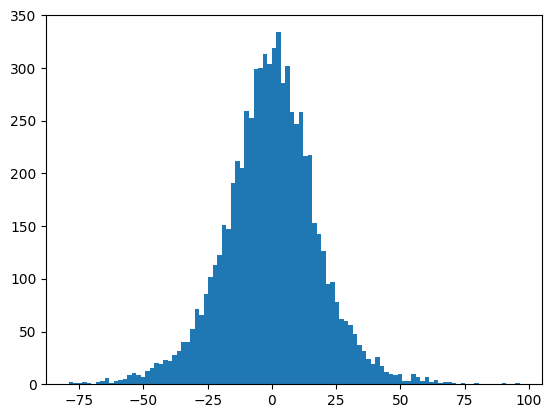

In [19]:
# histogram
#!pip install matplotlib
import matplotlib.pyplot as plt

total_emb = [value for line in final_embedding for value in line]
print(len(total_emb)) # 56*128 = 7168

plt.hist(total_emb, bins=100)

### 평가

In [7]:
import ast
#ground truth similarity 불러오기
ground_sim = pd.read_csv("/home/elicer/project/data/filtered_results.csv")


#ground sim에서 top 5 set뽑기
def extract_top_similar_ids(df_new):
    predicted_sets = []
    for _, row in df_new.iterrows():

        # 문자열을 리스트로 변환
        similarities = ast.literal_eval(row['Similarity'])

        # Similarity 기준으로 정렬 (높은 순)
        sorted_similarities = sorted(
            similarities, 
            key=lambda x: x[1] if isinstance(x[1], (int, float)) else 0, 
            reverse=True
        )
        
        # 현재 행의 File 값 제외하고 상위 5개 ID 추출
        top_5_ids = [
            id_sim[0] for id_sim in sorted_similarities 
            if id_sim[0] != row['File']
        ][:5]
        
        predicted_sets.append(top_5_ids)
    
    return predicted_sets

#ground_truth에서 전체 그냥 뽑기
def extract_all_similar_ids(df_new):
    all_predicted_ids = []
    for _, row in df_new.iterrows():
        # 문자열을 리스트로 변환
        similarities = ast.literal_eval(row['Similarity'])
        
        # 현재 행의 File 값 제외하고 모든 ID 추출
        ids = [id_sim[0] for id_sim in similarities if id_sim[0] != row['File']]
        
        all_predicted_ids.append(ids)  # 모든 ID를 리스트에 추가

    return all_predicted_ids


#recall평가
def calculate_recall_at_k(ground_truth, predictions, k=5):
    total_recall = 0
    for gt, pred in zip(ground_truth, predictions):
        # 교집합 계산
        intersection = len(set(gt) & set(pred))
        
        # Recall@k 계산
        recall = intersection / len(gt) if len(gt) > 0 else 0
        total_recall += recall
    
    # 평균 Recall@k
    return total_recall / len(ground_truth)

In [12]:
ground_truth = extract_top_similar_ids(ground_sim)
predicted_sets = anchor_df['SET'].tolist()

recall_5 = calculate_recall_at_k(ground_truth, predicted_sets, k=5)
print("Recall@5:", recall_5)

Recall@5: 0.006349206349206349


In [13]:
ground_all = extract_all_similar_ids(ground_sim)

recall_5 = calculate_recall_at_k(ground_all, predicted_sets, k=5)
print("Recall@5:", recall_5)

Recall@5: 0.005362472624377387


In [21]:
ground_10 = extract_top_similar_ids(ground_sim, k=10)
predicted_10 = anchor_df['SET_10'].tolist()

recall_10 = calculate_recall_at_k(ground_10, predicted_10, k=10)
print("Recall@10:", recall_10)

Recall@10: 0.007382212144116905


# WNS 모델 recall@10 - 1213 실행

In [3]:
ground_truth = extract_top_similar_ids(ground_sim, k=5)
anchor_df = pd.read_csv("top_all_set_WNS_model_1203_predicted.csv")
anchor_df.head()

,id,embedding,SET
0,TRAAABD128F429CF47,[ 0.296843 -10.305374 -5.2840333 -14.61...,"['TRRLFOQ128F147C837', 'TRFOOZJ128F1461183', '..."
1,TRAADNA128F9331246,[ 6.1910386 -6.832812 -5.54071 -9.20...,"['TRWESMP128F145FE46', 'TRZKOPA128F92FFB93', '..."
2,TRAADQX128F422B4CF,[-45.990276 1.0430254 23.494173 -42.12...,"['TRNUTRR128E0791306', 'TRAUEWN128F932C32C', '..."
3,TRAAGJV128F1464090,[-28.452686 -8.0084915 28.35335 -19.57...,"['TRJZRUB128F145993D', 'TRYXVJO128F14A3A77', '..."
4,TRAAPPQ128F14961F5,[ 7.5595975 8.436234 -11.273859 -10.15...,"['TRFTBQA128F1463713', 'TRADRLH128F4265C65', '..."


In [10]:


from sklearn.metrics.pairwise import cosine_similarity


#optimal에서 Anchor Id만 추출하기
optimal_df = pd.read_csv('/home/elicer/project/data/optimal_optimal_data.csv') 
filtered_optimal_df = optimal_df[optimal_df['IsInAnchor'] == 1] 
track_ids = filtered_optimal_df['Track ID'].tolist() #anchor의 track_id list

anchor_df = df[df['id'].isin(track_ids)] #anchor의 df (track_id + embedding)
anchor_embeddings = np.stack(anchor_df['embedding'].values)  # anchor의 임베딩 배열 

# Cosine Similarity 계산 및 Top 5 유사 음악 ID 추가
top10_sets = []
for i in range(len(anchor_embeddings)): #56개
    others_embeddings = np.stack(df['embedding'].values) #다른 모든 곡의 임베딩 배열
    
    # 현재 음악과 다른 모든 음악과의 유사도를 계산
    embeddings = anchor_embeddings[i] # 현재 음악(anchor 중 한개)

    similarities = [
        cosine_similarity(embeddings.reshape(1, -1), others_embeddings[j].reshape(1, -1)).flatten()
        for j in range(len(others_embeddings))
    ] # 한 앵커에 대해서 다른 노래들과 similarity 계산

    similarities = [item[0] for item in similarities] # value만 추출
    similarities = np.array(similarities)

    sorted_indices = similarities.argsort()[::-1]  # 유사도를 내림차순 정렬
    top10_indices = [idx for idx in sorted_indices if idx != i][:10]  # 자기 자신 제외하고 상위 5개

    top10_ids = df.iloc[top10_indices]['id'].tolist()  # 해당 인덱스의 ID 가져오기
    top10_sets.append(top10_ids)

# SET 칼럼 추가
anchor_df['SET_10'] = top10_sets


/tmp/ipykernel_169/1813335743.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anchor_df['SET_10'] = top10_sets


In [20]:
import ast
import pandas as pd
#ground truth similarity 불러오기
ground_sim = pd.read_csv("/home/elicer/project/data/filtered_results.csv")


#ground sim에서 top 10 set뽑기
def extract_top_similar_ids(df_new, k=10):
    predicted_sets = []
    for _, row in df_new.iterrows():

        # 문자열을 리스트로 변환
        similarities = ast.literal_eval(row['Similarity'])

        # Similarity 기준으로 정렬 (높은 순)
        sorted_similarities = sorted(
            similarities, 
            key=lambda x: x[1] if isinstance(x[1], (int, float)) else 0, 
            reverse=True
        )
        
        # 현재 행의 File 값 제외하고 상위 k개 ID 추출
        top_k_ids = [
            id_sim[0] for id_sim in sorted_similarities 
            if id_sim[0] != row['File']
        ][:k]
        
        predicted_sets.append(top_k_ids)
    
    return predicted_sets

#ground_truth에서 전체 그냥 뽑기
def extract_all_similar_ids(df_new):
    all_predicted_ids = []
    for _, row in df_new.iterrows():
        # 문자열을 리스트로 변환
        similarities = ast.literal_eval(row['Similarity'])
        
        # 현재 행의 File 값 제외하고 모든 ID 추출
        ids = [id_sim[0] for id_sim in similarities if id_sim[0] != row['File']]
        
        all_predicted_ids.append(ids)  # 모든 ID를 리스트에 추가

    return all_predicted_ids


#recall평가
def calculate_recall_at_k(ground_truth, predictions, k=5):
    total_recall = 0
    for gt, pred in zip(ground_truth, predictions):
        # 교집합 계산
        intersection = len(set(gt) & set(pred))
        
        # Recall@k 계산
        recall = intersection / len(gt) if len(gt) > 0 else 0
        total_recall += recall
    
    # 평균 Recall@k
    return total_recall / len(ground_truth)

In [14]:
ground_10 = extract_top_similar_ids(ground_sim, k=10)
predicted_10 = anchor_df['SET_10'].tolist()

recall_10 = calculate_recall_at_k(ground_10, predicted_10, k=10)
print("Recall@10:", recall_10)

Recall@10: 0.02171201814058957


# WNS_1214 불러와서 Test

In [8]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ast_encoder = ASTEncoder()
stage1_model = ContrastiveModel(ast_encoder)
stage1_model.load_state_dict(torch.load('/home/elicer/project/src/WNS_model_1214.pth'))  

stage1_model.eval()  # Stage 1은 학습하지 않음
stage1_model.to(device)

music_data = []

for batch in test_loader:

    clip_a, clip_b, file_ids = batch
    clip_a, clip_b= clip_a.to(device), clip_b.to(device)

    with torch.no_grad():  # Stage 1은 학습하지 않음
        stage1_model = stage1_model.to(clip_a.device)
        emb1,emb2 = stage1_model(clip_a, clip_b, device)
        emb1 = emb1.cpu().numpy()

    for file_id, embedding in zip(file_ids, emb1):
        music_data.append({'id': file_id, 'embedding': embedding})
    


df = pd.DataFrame(music_data)
df.to_csv("WNS_model_1214_predicted_embedding_all.csv", index=False)
print(df)

/tmp/ipykernel_154732/1520849035.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stage1_model.load_state_dict(torch.load('/home/elicer/project/src/WNS_model_1214.pth'))


Error processing index 353: empty range for randrange() (0, -651379, -651379)
                     id                                          embedding
0    TRAAABD128F429CF47  [-2.975463, -18.017086, 9.811185, 1.0033416, -...
1    TRAADNA128F9331246  [18.684723, -19.904085, 5.269379, 9.697008, 0....
2    TRAADQX128F422B4CF  [8.569063, 34.000446, 38.311455, 16.303291, -1...
3    TRAAGJV128F1464090  [-4.4608164, -11.7711735, -1.6261151, -28.8444...
4    TRAAPPQ128F14961F5  [21.9336, 17.185522, 17.304527, 9.907151, 11.8...
..                  ...                                                ...
675  TRZPDHG128F423EEAD  [-15.201846, -12.559383, 4.7674737, -6.7122555...
676  TRZTUFT128F9307C03  [4.822667, 2.6435773, 26.141388, -3.2883568, 1...
677  TRZVNSE128F14AA08B  [9.91453, 13.271329, 0.5270994, 27.860874, -10...
678  TRZVZFD128F1454730  [13.44834, -8.02242, -6.1997676, 24.615324, 4....
679  TRZXXKM128F42704D2  [-35.564438, -18.921162, -15.267945, -63.59013...

[680 rows x 2 columns

In [9]:
from sklearn.metrics.pairwise import cosine_similarity


#optimal에서 Anchor Id만 추출하기
optimal_df = pd.read_csv('/home/elicer/project/data/optimal_optimal_data.csv') 
filtered_optimal_df = optimal_df[optimal_df['IsInAnchor'] == 1] 
track_ids = filtered_optimal_df['Track ID'].tolist() #anchor의 track_id list

anchor_df = df[df['id'].isin(track_ids)] #anchor의 df (track_id + embedding)
anchor_embeddings = np.stack(anchor_df['embedding'].values)  # anchor의 임베딩 배열 

# Cosine Similarity 계산 및 Top 5 & 10 유사 음악 ID 추가
top5_sets = []
top10_sets = []

for i in range(len(anchor_embeddings)): #56개
    others_embeddings = np.stack(df['embedding'].values) #다른 모든 곡의 임베딩 배열
    
    # 현재 음악과 다른 모든 음악과의 유사도를 계산
    embeddings = anchor_embeddings[i] # 현재 음악(anchor 중 한개)

    similarities = [
        cosine_similarity(embeddings.reshape(1, -1), others_embeddings[j].reshape(1, -1)).flatten()
        for j in range(len(others_embeddings))
    ] # 한 앵커에 대해서 다른 노래들과 similarity 계산

    similarities = [item[0] for item in similarities] # value만 추출
    similarities = np.array(similarities)

    sorted_indices = similarities.argsort()[::-1]  # 유사도를 내림차순 정렬

    top5_indices = [idx for idx in sorted_indices if idx != i][:5]  # 자기 자신 제외하고 상위 5개
    top5_ids = df.iloc[top5_indices]['id'].tolist()  # 해당 인덱스의 ID 가져오기
    top5_sets.append(top5_ids)

    top10_indices = [idx for idx in sorted_indices if idx != i][:10]  # 자기 자신 제외하고 상위 10개
    top10_ids = df.iloc[top10_indices]['id'].tolist()  # 해당 인덱스의 ID 가져오기
    top10_sets.append(top10_ids)


# SET 칼럼 추가
anchor_df['SET_5'] = top5_sets
anchor_df['SET_10'] = top10_sets


/tmp/ipykernel_154732/2447929095.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anchor_df['SET_5'] = top5_sets
/tmp/ipykernel_154732/2447929095.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anchor_df['SET_10'] = top10_sets


In [16]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize


#optimal에서 Anchor Id만 추출하기
optimal_df = pd.read_csv('/home/elicer/project/data/optimal_optimal_data.csv') 
filtered_optimal_df = optimal_df[optimal_df['IsInAnchor'] == 1] 
track_ids = filtered_optimal_df['Track ID'].tolist() #anchor의 track_id list

anchor_df = df[df['id'].isin(track_ids)] #anchor의 df (track_id + embedding)
anchor_embeddings = np.stack(anchor_df['embedding'].values)  # anchor의 임베딩 배열 

ohters_df = df[~df['id'].isin(track_ids)]
others_embeddings = np.stack(ohters_df['embedding'].values)

all_embeddings = np.vstack([anchor_embeddings, others_embeddings])  # anchor와 다른 임베딩을 합침

normalized_embeddings = normalize(all_embeddings, norm='l2')

# 정규화된 앵커 임베딩과 다른 임베딩 분리하기
normalized_anchor_embeddings = normalized_embeddings[:len(anchor_embeddings)]  # 정규화된 앵커 임베딩
normalized_others_embeddings = normalized_embeddings[len(anchor_embeddings):]  # 정규화된 다른 임베딩

# Cosine Similarity 계산 및 Top 5&10 유사 음악 ID 추가
top5_sets = []
top10_sets = []

for i in range(len(anchor_embeddings)): #56개

    # 현재 음악과 다른 모든 음악과의 유사도를 계산
    normalized_embeddings = normalized_anchor_embeddings[i] # 현재 음악(anchor 중 한개)

    similarities = [
        cosine_similarity(normalized_embeddings.reshape(1, -1), normalized_others_embeddings[j].reshape(1, -1)).flatten()
        for j in range(len(normalized_others_embeddings))
    ] # 한 앵커에 대해서 다른 노래들과 similarity 계산

    similarities = [item[0] for item in similarities] # value만 추출
    similarities = np.array(similarities)

    sorted_indices = similarities.argsort()[::-1]  # 유사도를 내림차순 정렬

    top5_indices = [idx for idx in sorted_indices if idx != i][:5]  # 자기 자신 제외하고 상위 5개
    top5_ids = df.iloc[top5_indices]['id'].tolist()  # 해당 인덱스의 ID 가져오기
    top5_sets.append(top5_ids)

    top10_indices = [idx for idx in sorted_indices if idx != i][:10]  # 자기 자신 제외하고 상위 10개
    top10_ids = df.iloc[top10_indices]['id'].tolist()  # 해당 인덱스의 ID 가져오기
    top10_sets.append(top10_ids)

# SET 칼럼 추가
anchor_df['SET_5_norm'] = top5_sets
anchor_df['SET_10_norm'] = top10_sets

/tmp/ipykernel_154732/4054025529.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anchor_df['SET_5_norm'] = top5_sets
/tmp/ipykernel_154732/4054025529.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anchor_df['SET_10_norm'] = top10_sets


In [22]:
anchor_df.to_csv("WNS_model_1214_normalized.csv", index=False)

In [10]:
import ast
import pandas as pd
#ground truth similarity 불러오기
ground_sim = pd.read_csv("/home/elicer/project/data/filtered_results.csv")


#ground sim에서 top 10 set뽑기
def extract_top_similar_ids(df_new, k=10):
    predicted_sets = []
    for _, row in df_new.iterrows():

        # 문자열을 리스트로 변환
        similarities = ast.literal_eval(row['Similarity'])

        # Similarity 기준으로 정렬 (높은 순)
        sorted_similarities = sorted(
            similarities, 
            key=lambda x: x[1] if isinstance(x[1], (int, float)) else 0, 
            reverse=True
        )
        
        # 현재 행의 File 값 제외하고 상위 k개 ID 추출
        top_k_ids = [
            id_sim[0] for id_sim in sorted_similarities 
            if id_sim[0] != row['File']
        ][:k]
        
        predicted_sets.append(top_k_ids)
    
    return predicted_sets

#ground_truth에서 전체 그냥 뽑기
def extract_all_similar_ids(df_new):
    all_predicted_ids = []
    for _, row in df_new.iterrows():
        # 문자열을 리스트로 변환
        similarities = ast.literal_eval(row['Similarity'])
        
        # 현재 행의 File 값 제외하고 모든 ID 추출
        ids = [id_sim[0] for id_sim in similarities if id_sim[0] != row['File']]
        
        all_predicted_ids.append(ids)  # 모든 ID를 리스트에 추가

    return all_predicted_ids


#recall평가
def calculate_recall_at_k(ground_truth, predictions, k=5):
    total_recall = 0
    for gt, pred in zip(ground_truth, predictions):
        # 교집합 계산
        intersection = len(set(gt) & set(pred))
        
        # Recall@k 계산
        recall = intersection / len(gt) if len(gt) > 0 else 0
        total_recall += recall
    
    # 평균 Recall@k
    return total_recall / len(ground_truth)

In [11]:
ground_5 = extract_top_similar_ids(ground_sim, k=5)
predicted_5 = anchor_df['SET_5'].tolist()

recall_5 = calculate_recall_at_k(ground_5, predicted_5, k=5)
print("Recall@5:", recall_5)

Recall@5: 0.0


In [12]:
ground_10 = extract_top_similar_ids(ground_sim, k=10)
predicted_10 = anchor_df['SET_10'].tolist()

recall_10 = calculate_recall_at_k(ground_10, predicted_10, k=10)
print("Recall@10:", recall_10)

Recall@10: 0.003854875283446712


In [18]:
ground_5 = extract_top_similar_ids(ground_sim, k=5)
predicted_5 = anchor_df['SET_5_norm'].tolist()

recall_5 = calculate_recall_at_k(ground_5, predicted_5, k=5)
print("Recall@5:", recall_5)

Recall@5: 0.0031746031746031746


In [19]:
ground_10 = extract_top_similar_ids(ground_sim, k=10)
predicted_10 = anchor_df['SET_10_norm'].tolist()

recall_10 = calculate_recall_at_k(ground_10, predicted_10, k=10)
print("Recall@10:", recall_10)

Recall@10: 0.016773746535651297


In [21]:
#Norm한 Recall@5 결과 출력
for gt, pred in zip(ground_5, predicted_5):
    intersection = set(gt) & set(pred)
    print("Ground Truth:", gt)
    print("Predicted:", pred)
    print("Intersection:", intersection)

Ground Truth: ['TRBRSNN128F4284E8C', 'TRZCLXJ128F429CF49', 'TRHXIRT12903CB22B5', 'TRCMXJZ12903CB2303', 'TRIIGSO12903CDFB67']
Predicted: ['TRIXJSX128E0791734', 'TRAMGJJ128F421487E', 'TRJHWMF128E0787385', 'TRCKPZJ128F92CA494', 'TRNDEAK128F4266CF3']
Intersection: set()
Ground Truth: ['TRSLCDZ128E07847D6', 'TRLIQKZ128F92DE242', 'TRVXNLW128F932A2EA', 'TRPMHHP128F933DB50', 'TRIGAEW128F933DB3C']
Predicted: ['TRIPIGS128F4284BA5', 'TRRNUHX128F9305B95', 'TRSOLWT128F932DFFF', 'TRGBVDZ128EF356AF9', 'TREMGLA128F931FAB3']
Intersection: set()
Ground Truth: ['TRBWFIV128F9331289', 'TRDHRYP128F427906F', 'TRDVWVL128F42655EA', 'TRTAVUY128F145A647', 'TRUYVOM128E0791A7E']
Predicted: ['TRIHNYM128F92FB61C', 'TRAMGAZ128F148D4C3', 'TRJMICM128F42480C6', 'TRAUMNH128F92FB67F', 'TROOWWY128F14560A8']
Intersection: set()
Ground Truth: ['TRBEAWP128F422B4D1', 'TROHCDR128F422B4D0', 'TRJBGYJ128F935577C', 'TRUDGJY128F93557B2', 'TRGKJJT128F92EDA64']
Predicted: ['TRNGYKQ128F14591AC', 'TRROADI128F4259A9D', 'TRISMIC128F42739C

# WNS_1203 불러와서 precision@30

In [11]:
import ast
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np 
import re

#함수
#ground_truth에서 전체 그냥 뽑기
def extract_all_similar_ids(df_new, optimal_df):
    all_predicted_ids = []
    track_id = optimal_df['Track ID'].tolist()

    for _, row in df_new.iterrows():
        # 문자열을 리스트로 변환
          if row['File'] in track_id:
            # 문자열을 리스트로 변환
            similarities = ast.literal_eval(row['Similarity'])
            
            # 현재 행의 File 값 제외하고 모든 ID 추출
            ids = [id_sim[0] for id_sim in similarities if id_sim[0] != row['File']]
            
            all_predicted_ids.append(ids)  # 모든 ID를 리스트에 추가

    return all_predicted_ids



def read_embedding(embedding_str):
        
    # 1. 대괄호 제거
    embedding_str = embedding_str.strip('[]')

    # 2. 공백과 줄바꿈으로 구분된 숫자 추출
    embedding_list = list(map(float, re.split(r'\s+', embedding_str.strip())))

    return embedding_list




#predicted value 30개 뽑기
def extract_top_k_predicted(df, optimal_df, k=30):
    filtered_optimal_df = optimal_df[optimal_df['IsInAnchor'] == 1] 
    track_ids = filtered_optimal_df['Track ID'].tolist() #anchor의 track_id list

    anchor_df = df[df['id'].isin(track_ids)] #anchor의 df (track_id + embedding)
    
    embeddings_all_str = df["embedding"].tolist()
    embeddings_all = np.array([read_embedding(line) for line in embeddings_all_str])

    anchor_embeddings_str = anchor_df["embedding"].tolist()
    anchor_embeddings = np.array([read_embedding(line) for line in anchor_embeddings_str])
    

    # Cosine Similarity 계산 및 Top  유사 음악 ID 추가
    top_sets = []
    for i in range(len(anchor_embeddings)): #56개
        # 현재 음악과 다른 모든 음악과의 유사도를 계산
        embeddings = anchor_embeddings[i] # 현재 음악(anchor 중 한개)

        similarities = [
            cosine_similarity(embeddings.reshape(1, -1), embeddings_all[j].reshape(1, -1)).flatten()
            for j in range(len(embeddings_all))
        ] # 한 앵커에 대해서 다른 노래들과 similarity 계산

        similarities = [item[0] for item in similarities] # value만 추출
        similarities = np.array(similarities)

        sorted_indices = similarities.argsort()[::-1]  # 유사도를 내림차순 정렬
        top_indices = [idx for idx in sorted_indices if idx != i][:k]  # 자기 자신 제외하고 상위 5개

        top_ids = df.iloc[top_indices]['id'].tolist()  # 해당 인덱스의 ID 가져오기
        top_sets.append(top_ids)

    # SET 칼럼 추가
    anchor_df['SET'] = top_sets

    return anchor_df


#precision평가
def calculate_precision(ground_truth, predictions):
    total_precision = 0
    predicted_anchor = predictions
    predicted_sets = predictions['SET'].tolist()
    for gt, pred in zip(ground_truth,  predicted_sets):
        # 교집합 계산
        intersection = len(set(gt) & set(pred))
        print("intersection", intersection)
        print("len of pred", len(pred))
        
        # precision@k 계산
        precision = intersection / len(pred) if len(pred) > 0 else 0
        print("each precision", precision)
        total_precision += precision
    
    # 평균 precision@k
    return total_precision / len(predicted_sets)


#recall평가
def calculate_recall_at_k(ground_truth, predictions):
    total_recall = 0

    predicted_sets = predictions['SET'].tolist()
    for gt, pred in zip(ground_truth, predicted_sets):
        # 교집합 계산
        intersection = len(set(gt) & set(pred))
        
        # Recall@k 계산
        recall = intersection / len(gt) if len(gt) > 0 else 0
        total_recall += recall
    
    # 평균 Recall@k
    return total_recall / len(ground_truth)

In [12]:
#데이터 불러오기
ground_sim = pd.read_csv("/home/elicer/project/data/filtered_results.csv")
predicted_all= pd.read_csv("/home/elicer/project/collect_data/WNS_model_1203_predicted_embedding_all.csv")
optimal_df = pd.read_csv('/home/elicer/project/data/optimal_optimal_data.csv')


In [18]:

predicted_10 = extract_top_k_predicted(predicted_all, optimal_df, k=10)

ground_all=extract_all_similar_ids(ground_sim, optimal_df)

calculate_recall_at_k(ground_all, predicted_10)

/tmp/ipykernel_49907/3063746647.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anchor_df['SET'] = top_sets


0.05811367829030872

In [15]:

predicted_10 = extract_top_k_predicted(predicted_all, optimal_df, k=10)

ground_all=extract_all_similar_ids(ground_sim, optimal_df)

calculate_precision(ground_all, predicted_10)

intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 1
len of pred 10
each precision 0.1
intersection 1
len of pred 10
each precision 0.1
intersection 0
len of pred 10
each precision 0.0
intersection 1
len of pred 10
each precision 0.1
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 1
len of pred 10
each precision 0.1
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 1
len of pred 10
each precision 0.1
intersection 0
len of pred 10
each precision 0.0
intersection 0
len o

/tmp/ipykernel_49907/3063746647.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anchor_df['SET'] = top_sets


0.0517857142857143

In [17]:
print(len(predicted_10))
print(len(ground_all))

56
56


In [20]:


predicted_30 = extract_top_k_predicted(predicted_all, optimal_df, k=30)

ground_all=extract_all_similar_ids(ground_sim,optimal_df)

calculate_precision(ground_all, predicted_30)

intersection 0
len of pred 30
each precision 0.0
intersection 0
len of pred 30
each precision 0.0
intersection 0
len of pred 30
each precision 0.0
intersection 0
len of pred 30
each precision 0.0
intersection 1
len of pred 30
each precision 0.03333333333333333
intersection 1
len of pred 30
each precision 0.03333333333333333
intersection 1
len of pred 30
each precision 0.03333333333333333
intersection 0
len of pred 30
each precision 0.0
intersection 1
len of pred 30
each precision 0.03333333333333333
intersection 1
len of pred 30
each precision 0.03333333333333333
intersection 0
len of pred 30
each precision 0.0
intersection 1
len of pred 30
each precision 0.03333333333333333
intersection 2
len of pred 30
each precision 0.06666666666666667
intersection 0
len of pred 30
each precision 0.0
intersection 1
len of pred 30
each precision 0.03333333333333333
intersection 2
len of pred 30
each precision 0.06666666666666667
intersection 0
len of pred 30
each precision 0.0
intersection 0
len of p

/tmp/ipykernel_49907/3063746647.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anchor_df['SET'] = top_sets


0.03452380952380955

In [21]:

predicted_sets = predicted_30['SET'].tolist()
for gt, pred in zip(ground_all, predicted_sets):
    intersection = set(gt) & set(pred)
    print("Ground Truth:", gt)
    print("Predicted:", pred)
    print("Intersection:", intersection)

Ground Truth: ['TRBRSNN128F4284E8C', 'TRZCLXJ128F429CF49', 'TRHXIRT12903CB22B5', 'TRCMXJZ12903CB2303', 'TRIIGSO12903CDFB67', 'TRRETPJ128F423424B', 'TRGBFMF128F933801B', 'TRYYXQB12903D10BCC', 'TRFYRVZ128F92EF998', 'TRZNONX12903CEA3DC', 'TRSPFSP128F425D93F', 'TRBUWIW128F14A3A8F', 'TRJZRUB128F145993D', 'TRWVEGG128F429EF50', 'TRRVYKU128F935E3C4', 'TRYKDKV128F42608A8', 'TRUICXF128F1474540', 'TRYFZZT128E0790AD2', 'TRSEKVZ12903CBD4AE']
Predicted: ['TRMVWBS128F148EEB6', 'TRFOOZJ128F1461183', 'TRZODUN128F42440AB', 'TRICYAV128F4268D30', 'TRRLFOQ128F147C837', 'TRIDKSY12903CDDA7F', 'TRMMATD128F932C32B', 'TRFCJDN12903CEA556', 'TRUBUZA128E0794381', 'TRADNRG128F4295A0E', 'TRUXHNO128F933268B', 'TRDTQJI128F92E37A7', 'TRRVDDS128F426F4B7', 'TRZCZIB128F92E379B', 'TRGUGPC12903CB81A7', 'TRNOCDH128F42812B2', 'TRTXORS128F92FA8DB', 'TRKUYTM128F42B775C', 'TRBZNMB128F9307828', 'TRFROOK12903D0F9CA', 'TRJTZXI128F4289C71', 'TRVXAYW128F426569F', 'TRTKEHA128F4267D2D', 'TRLYEIL128E0782AC4', 'TRHAWEE128F9326748', 'TRYY

In [4]:
predicted_50 = extract_top_k_predicted(predicted_all, optimal_df, k=50)

ground_all=extract_all_similar_ids(ground_sim)

calculate_precision(ground_all, predicted_50)

intersection 0
len of pred 50
each precision 0.0
intersection 0
len of pred 50
each precision 0.0
intersection 0
len of pred 50
each precision 0.0
intersection 0
len of pred 50
each precision 0.0
intersection 1
len of pred 50
each precision 0.02
intersection 1
len of pred 50
each precision 0.02
intersection 1
len of pred 50
each precision 0.02
intersection 1
len of pred 50
each precision 0.02
intersection 2
len of pred 50
each precision 0.04
intersection 1
len of pred 50
each precision 0.02
intersection 1
len of pred 50
each precision 0.02
intersection 0
len of pred 50
each precision 0.0
intersection 2
len of pred 50
each precision 0.04
intersection 0
len of pred 50
each precision 0.0
intersection 1
len of pred 50
each precision 0.02
intersection 0
len of pred 50
each precision 0.0
intersection 0
len of pred 50
each precision 0.0
intersection 1
len of pred 50
each precision 0.02
intersection 0
len of pred 50
each precision 0.0
intersection 0
len of pred 50
each precision 0.0
intersecti

/tmp/ipykernel_197610/2404853626.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anchor_df['SET'] = top_sets


0.015

### recall 10 - wns1203

In [10]:
predicted_10 = extract_top_k_predicted(predicted_all, optimal_df, k=10)

ground_all=extract_all_similar_ids(ground_sim)

calculate_recall_at_k(ground_all, predicted_10)

/tmp/ipykernel_35637/2264213459.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anchor_df['SET'] = top_sets


0.019886843626339423

In [17]:
#precision10 of WNS_1214

ground_sim = pd.read_csv("/home/elicer/project/data/filtered_results.csv")
predicted_all= pd.read_csv("/home/elicer/project/collect_data/WNS_model_1214_predicted_embedding_all.csv")
optimal_df = pd.read_csv('/home/elicer/project/data/optimal_optimal_data.csv')

predicted_10 = extract_top_k_predicted(predicted_all, optimal_df, k=10)

ground_all=extract_all_similar_ids(ground_sim)

calculate_precision(ground_all, predicted_10)

intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 1
len of pred 10
each precision 0.1
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len o

/tmp/ipykernel_35637/2264213459.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anchor_df['SET'] = top_sets


0.005357142857142858

In [15]:
#precision10 of NS_1203

ground_sim = pd.read_csv("/home/elicer/project/data/filtered_results.csv")
predicted_all= pd.read_csv("/home/elicer/project/collect_data/NS_model_1203_predicted_embedding_all.csv")
optimal_df = pd.read_csv('/home/elicer/project/data/optimal_optimal_data.csv')

predicted_10 = extract_top_k_predicted(predicted_all_ns, optimal_df, k=10)

ground_all=extract_all_similar_ids(ground_sim)

calculate_precision(ground_all, predicted_10)

intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 1
len of pred 10
each precision 0.1
intersection 0
len of pred 10
each precision 0.0
intersection 1
len of pred 10
each precision 0.1
intersection 1
len of pred 10
each precision 0.1
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len of pred 10
each precision 0.0
intersection 0
len o

/tmp/ipykernel_35637/2264213459.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anchor_df['SET'] = top_sets


0.014285714285714285

In [11]:
#recall10 of NS_1203

ground_sim = pd.read_csv("/home/elicer/project/data/filtered_results.csv")
predicted_all_ns= pd.read_csv("/home/elicer/project/collect_data/NS_model_1203_predicted_embedding_all.csv")
optimal_df = pd.read_csv('/home/elicer/project/data/optimal_optimal_data.csv')


predicted_10 = extract_top_k_predicted(predicted_all_ns, optimal_df, k=10)

ground_all=extract_all_similar_ids(ground_sim)

calculate_recall_at_k(ground_all, predicted_10)

/tmp/ipykernel_35637/2264213459.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anchor_df['SET'] = top_sets


0.01251241237235635

### WNS_model_1203 with norm 

In [11]:
import ast
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np 
import re

#함수
#ground_truth에서 전체 그냥 뽑기
def extract_all_similar_ids(df_new):
    all_predicted_ids = []
    for _, row in df_new.iterrows():
        # 문자열을 리스트로 변환
        similarities = ast.literal_eval(row['Similarity'])
        
        # 현재 행의 File 값 제외하고 모든 ID 추출
        ids = [id_sim[0] for id_sim in similarities if id_sim[0] != row['File']]
        
        all_predicted_ids.append(ids)  # 모든 ID를 리스트에 추가

    return all_predicted_ids



def read_embedding(embedding_str):
        
    # 1. 대괄호 제거
    embedding_str = embedding_str.strip('[]')

    # 2. 공백과 줄바꿈으로 구분된 숫자 추출
    embedding_list = list(map(float, re.split(r'\s+', embedding_str.strip())))

    return embedding_list




#predicted value 30개 뽑기
def extract_top_k_predicted(df, optimal_df, k=30):
    filtered_optimal_df = optimal_df[optimal_df['IsInAnchor'] == 1] 
    track_ids = filtered_optimal_df['Track ID'].tolist() #anchor의 track_id list

    anchor_df = df[df['id'].isin(track_ids)] #anchor의 df (track_id + embedding)
    
    embeddings_all_str = df["embedding"].tolist()
    embeddings_all = np.array([read_embedding(line) for line in embeddings_all_str])

    anchor_embeddings_str = anchor_df["embedding"].tolist()
    anchor_embeddings = np.array([read_embedding(line) for line in anchor_embeddings_str])
    

    # Cosine Similarity 계산 및 Top  유사 음악 ID 추가
    top_sets = []
    for i in range(len(anchor_embeddings)): #56개
        # 현재 음악과 다른 모든 음악과의 유사도를 계산
        embeddings = anchor_embeddings[i] # 현재 음악(anchor 중 한개)

        similarities = [
            cosine_similarity(embeddings.reshape(1, -1), embeddings_all[j].reshape(1, -1)).flatten()
            for j in range(len(embeddings_all))
        ] # 한 앵커에 대해서 다른 노래들과 similarity 계산

        similarities = [item[0] for item in similarities] # value만 추출
        similarities = np.array(similarities)

        sorted_indices = similarities.argsort()[::-1]  # 유사도를 내림차순 정렬
        top_indices = [idx for idx in sorted_indices if idx != i][:k]  # 자기 자신 제외하고 상위 5개

        top_ids = df.iloc[top_indices]['id'].tolist()  # 해당 인덱스의 ID 가져오기
        top_sets.append(top_ids)

    # SET 칼럼 추가
    anchor_df['SET'] = top_sets

    return anchor_df


#precision평가
def calculate_precision(ground_truth, predictions):
    total_precision = 0

    predicted_sets = predictions['SET'].tolist()
    for gt, pred in zip(ground_truth,  predicted_sets):
        # 교집합 계산
        intersection = len(set(gt) & set(pred))
        print("intersection", intersection)
        print("len of pred", len(pred))
        
        # precision@k 계산
        precision = intersection / len(pred) if len(pred) > 0 else 0
        print("each precision", precision)
        total_precision += precision
    
    # 평균 precision@k
    return total_precision / len(predicted_sets)


#recall평가
def calculate_recall_at_k(ground_truth, predictions):
    total_recall = 0

    predicted_sets = predictions['SET'].tolist()
    for gt, pred in zip(ground_truth, predicted_sets ):
        # 교집합 계산
        intersection = len(set(gt) & set(pred))
        
        # Recall@k 계산
        recall = intersection / len(gt) if len(gt) > 0 else 0
        total_recall += recall
    
    # 평균 Recall@k
    return total_recall / len(ground_truth)

In [ ]:

ground_sim = pd.read_csv("/home/elicer/project/data/filtered_results.csv")
predicted_all_ns= pd.read_csv("/home/elicer/project/collect_data/WNS_model_1203_predicted_embedding_all.csv")
optimal_df = pd.read_csv('/home/elicer/project/data/optimal_optimal_data.csv')


#recall@5
predicted_5 = extract_top_k_predicted(predicted_all, optimal_df, k=5)

ground_all=extract_all_similar_ids(ground_sim)

calculate_precision(ground_all, predicted_30)